In [22]:
import numpy as np
%pylab inline
style.use('ggplot')

# rolling sum for onsets
def stack_onsets(arr):
    stacked = [];c=0.
    for o in arr:
        stacked.append(c+o)
        c+=o
    return np.array(stacked)

# bin onsets by bin_len second?
def bin_onsets(arr,bin_len):
    n_bins = (np.ceil(np.max(arr) / bin_len)) + 1
    bins = np.zeros(n_bins)
    for o in arr:
#         print np.round(o / bin_len)
        bins[np.round(o / bin_len)] += 1
    return np.array(bins)
        

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## we want our curve to look like this

![ionizing vs alt](http://rocketsetc.com/wp-content/uploads/2015/05/hab2-geiger2.png)

### estimating this graph and converting ft to time

In [23]:
ascent_fps = 6 # feet per second
bin_len = 10 # length in second of bins
sc = 20 # scaling factor of trend
total_time = 18000 # total time ascending

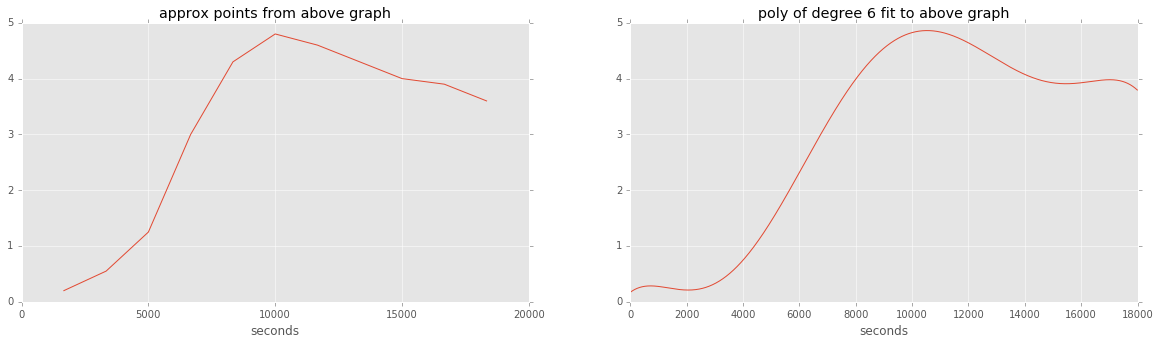

In [24]:
# manually done from graph above
x = np.array([10, 20,  30,40,50,60,70,80,90,100,110]) * 1e3 / ascent_fps
y = np.array([.2,.55,1.25, 3,4.3,4.8,4.6,4.3,4,3.9,3.6])

time_points = np.arange(0,total_time,bin_len)

coefs = np.polyfit(x,y,6) # creating a 6 degree poly to fit this data
# (6 seems to be pretty solid but is completely arbitrary)
poly_y = np.poly1d(coefs) # flattening it?

ys = poly_y(time_points) # fitting this poly to time vector 

figure(figsize=(20,5))
subplot(121)
title('approx points from above graph')
xlabel('seconds')
plot(x,y)
subplot(122)
title('poly of degree 6 fit to above graph')
xlabel('seconds')

plot(np.arange(0,18000,10),ys);show()

### Create onsets of pulses with size in (0,1/div_factor)

In [25]:
div_factor = 4. # completely arbitrary fudge factor to make shit work
# basically this is saying give us about 10 samples per second
n_onsets = np.ceil(np.max(x)) * 10

In [26]:
# these are the raw random numbers in range (0,1/div_factor)
onsetsG1 = np.random.random(size=n_onsets) / div_factor
onsetsG2 = np.random.random(size=n_onsets) / div_factor
onsetsP = np.random.random(size=n_onsets) / div_factor
print onsetsG1

[ 0.12027909  0.11620756  0.14999239 ...,  0.16826547  0.0926138
  0.19913655]


# make these numbers into a running sum

In [27]:
onsetsG1 = stack_onsets(onsetsG1)
onsetsG2 = stack_onsets(onsetsG2)
onsetsP = stack_onsets(onsetsP)
print onsetsG1

[  1.20279089e-01   2.36486646e-01   3.86479036e-01 ...,   2.29250475e+04
   2.29251401e+04   2.29253393e+04]


In [32]:
# hacky bullshit to not go over time ; go with it for now
onsetsG1 = onsetsG1[onsetsG1 < np.max(x) -10]
onsetsG2 = onsetsG2[onsetsG2 < np.max(x) -10]
onsetsP = onsetsP[onsetsP < np.max(x) -10]
onsetsG1[:min(map(lambda x : x.shape[0],onsets))]
onsetsG2[:min(map(lambda x : x.shape[0],onsets))]
onsetsP[:min(map(lambda x : x.shape[0],onsets))]
onsets = [onsetsG1,onsetsG2,onsetsP]
print map(max,onsets)
print map(lambda x: x.shape,onsets)

[18323.157931852569, 18323.21666714879, 18323.311576585915]
[(146389,), (146437,), (146517,)]


## we gunna add this shit to the random data so it looks like what that graph says

In [ ]:
# ceil of highest value in our time_points
max_time = np.ceil(np.max(map(max,onsets))) + 10
print 'highest time : {}'.format(max_time)

binnedG1 = bin_onsets(onsetsG1,bin_len)
binnedG2 = bin_onsets(onsetsG2,bin_len)
binnedP = bin_onsets(onsetsP,bin_len)

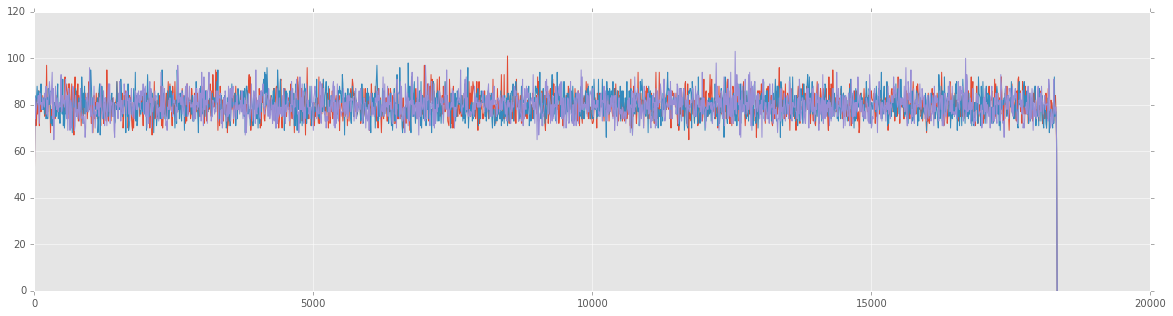

In [41]:
x_time_points = np.arange(0,max_time,bin_len)
figure(figsize=(20,5))
plot(x_time_points,binnedG1,lw=1)
plot(x_time_points,binnedG2,lw=1)
plot(x_time_points,binnedP,lw=1)

In [37]:
y_trend = poly_y(x_time_points)

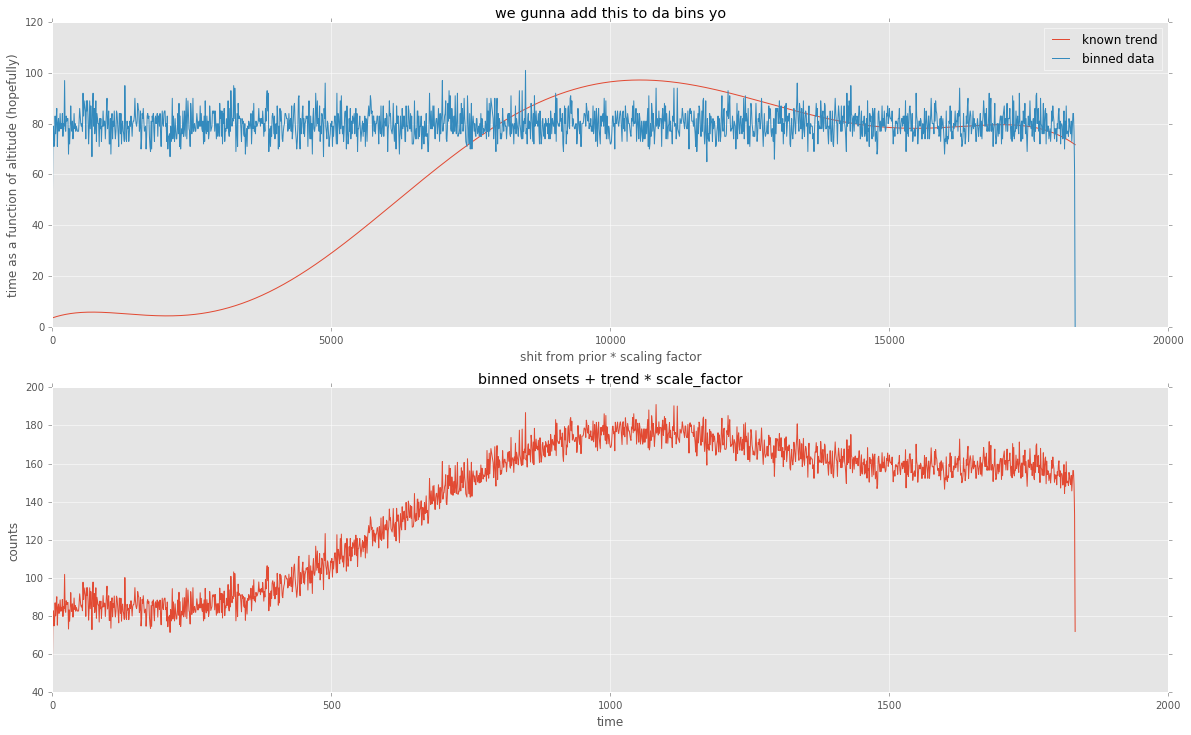

In [40]:
figure(figsize=(20,12))
subplot(211)
plot(x_time_points,y_trend * sc,label='known trend')
plot(x_time_points,binnedG1,label='binned data')
title('we gunna add this to da bins yo')
xlabel('shit from prior * scaling factor')
ylabel('time as a function of altitude (hopefully)')
legend()
subplot(212)
plot(binnedG1 + (y_trend * sc))
title('binned onsets + trend * scale_factor')
xlabel('time')
ylabel('counts');show()

In [12]:
# NEXT : 
    # add muons and change PD to only have gamma cuz right now they ==
    # bin all 3 time series (problem with polyfit vector length)
    # try out equation on them to see if we get anything

In [ ]:
scores = []
best_score = 1e10
step_size = 5
bin_range = np.arange(2,5000,step_size)
for i in bin_range:
    b1 = bin_onsets(onsetsG1,i)
    b2 = bin_onsets(onsetsG2,i)
    s_diff = np.abs(np.std(b1) - np.std(b2))
    m_diff = np.abs(np.mean(b1) - np.mean(b2))
    score = s_diff + np.power(m_diff,-1)
    scores.append(score)
    if score < best_score and i % 10 == 0:
        print "bin size : {} | score : {} | s_diff : {} | m_diff : {} |".format(i,score,s_diff,m_diff)
        best_score = score

In [ ]:
x = np.arange(0,len(scores) * step_size,step_size)
ds = np.diff(scores)
dx = np.arange(0,len(ds) * step_size,step_size)

figure(figsize=(20,5))
subplot(121)
plot(x,scores);title('scores')
annotate('min = ( {} , {} )'.format(argmin(scores)*step_size,min(scores)),
         xy = (argmin(scores)*step_size, scores[argmin(scores)] ),
         xytext = (argmin(scores) * step_size + 20,scores[argmin(scores)] + 20),
         arrowprops=dict(facecolor='black',width=5))
subplot(122)
plot(dx,ds);title("scores'")

In [34]:
argmin(scores)

58

## currently seperate from above ; sympy shit for our fancy matrix equation 

In [1]:
from sympy.interactive import printing
printing.init_printing()

In [8]:
from sympy import Function, symbols, sqrt, S ,Sum, Abs, Matrix

In [9]:
P_b,Q_y,C1,C2,C3,P_g = symbols("P_B Q_\gamma C_1 C_2 C_3 P_{\gamma}")

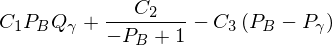

In [10]:
expr = P_b * Q_y * C1 + C2/(1-P_b) - C3 * (P_b - P_g)
expr

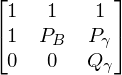

In [11]:
X = Matrix([[1,1,1],[1,P_b,P_g],[0,0,Q_g]])
X

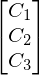

In [12]:
C = Matrix([[C1,C2,C3]]).T
C

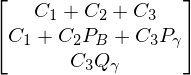

In [13]:
X*C

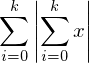

In [17]:
Sum(Abs(Sum(x,[i,0,k])),[i,0,k])